In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import skextremes as ske

!pip install xlrd

  Using cached xlrd-1.2.0-py2.py3-none-any.whl (103 kB)


In [6]:
flow60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                        sheet_name = 1)
flow60_filtered = flow60.replace(" ---", np.nan)
flow60_filtered['Flow [m³/s]'] = pd.to_numeric(
    flow60_filtered['Flow [m³/s]'], downcast="float")

In [7]:
stage60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                          sheet_name = 2)
stage60_filtered = stage60.replace(" ---", np.nan)
stage60_filtered['Stage [m]'] = pd.to_numeric(
    stage60_filtered['Stage [m]'], downcast="float")

In [8]:
rainfall60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                           sheet_name=3)
rainfall60_filtered = rainfall60.replace(
    " ---", np.nan).replace(".", np.nan).replace("  ---", np.nan)
rainfall60_filtered['Precipitation [mm]'] = pd.to_numeric(
    rainfall60_filtered['Precipitation [mm]'], downcast="float")

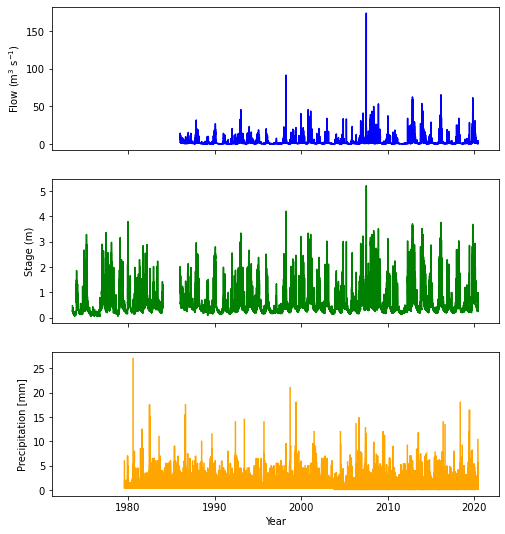

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 3*3), sharex=True)
axes[0].plot(flow60_filtered['Date'], flow60_filtered['Flow [m³/s]'], 'blue')
axes[0].set_ylabel("Flow (m$^3$ s$^{-1}$)")
axes[1].plot(stage60_filtered['Date'], stage60_filtered['Stage [m]'], 'green')
axes[1].set_ylabel("Stage (m)")
axes[2].plot(rainfall60_filtered['Date'], rainfall60_filtered['Precipitation [mm]'], 'orange')
axes[2].set_ylabel('Precipitation [mm]')
axes[2].set_xlabel('Year')
plt.savefig('../report/figures/wiski_60min_lineplots.png', dpi=600, bbox_inches='tight')
plt.savefig('../report/figures/wiski_60min_lineplots.pdf', bbox_inches='tight')

In [10]:
def take_block_maxima(dataframe, key):
    
    date_time = []
    
    for i in range(len(dataframe['Time'])):
        
        time = dataframe['Time'][i]
        date = datetime.datetime.utcfromtimestamp(
            dataframe['Date'].to_numpy()[i].tolist()/1e9).date()
        date_time.append(datetime.datetime.combine(date, time))
        
    dataframe = dataframe.assign(datetime = date_time)
    dataframe = dataframe.set_index('datetime')    
    max_df = dataframe.groupby(lambda x: x.year)[key].agg(['mean', 'max'])
    
    return max_df

In [11]:
# max_rainfall60 = take_block_maxima(rainfall60_filtered, 'Precipitation [mm]')
max_stage60 = take_block_maxima(stage60_filtered, 'Stage [m]')
max_flow60 = take_block_maxima(flow60_filtered, 'Flow [m³/s]')

In [115]:
stage60_filtered['Date'] # .to_numpy()

0        1973-07-23
1        1973-07-23
2        1973-07-23
3        1973-07-23
4        1973-07-23
            ...    
411464   2020-06-30
411465   2020-06-30
411466   2020-06-30
411467   2020-06-30
411468   2020-06-30
Name: Date, Length: 411469, dtype: datetime64[ns]

In [126]:
# stage60_filtered['Date'].to_numpy()[0].astype(datetime.datetime)
datetime.datetime.utcfromtimestamp(stage60_filtered['Date'].to_numpy()[0].tolist()/1e9)

datetime.datetime(1973, 7, 23, 0, 0)

In [137]:
time = stage60_filtered['Time'][0]

In [142]:
date = datetime.datetime.utcfromtimestamp(
    stage60_filtered['Date'].to_numpy()[0].tolist()/1e9).date()

In [165]:
datetime.datetime.combine(date, time)

datetime.datetime(2020, 6, 30, 23, 0)

In [14]:
max_stage60['max'].to_numpy().dropnans()

array([0.472, 2.673, 3.287, 2.683, 3.362, 2.978, 3.796, 1.989, 2.845,
       2.889, 2.235, 1.307,   nan, 2.14 , 2.963, 2.535, 2.462, 2.8  ,
       1.995, 2.99 , 3.343, 2.672, 2.515, 1.948, 1.524, 4.206, 3.209,
       3.341, 3.294, 2.386, 3.026, 3.016, 3.005, 2.938, 5.212, 3.516,
       2.33 , 3.126, 1.525, 3.708, 3.526, 3.307, 2.874, 3.764, 2.688,
       3.037, 3.686, 2.937], dtype=float32)

In [189]:
max_flow60 

,mean,max
1986,1.917465,15.30
1987,1.702134,31.80
1988,1.460123,19.80
1989,1.078647,18.10
1990,1.127205,26.80
1991,0.779589,14.10
1992,1.685676,32.70
1993,1.500331,45.70
1994,1.698200,23.20
1995,1.433528,20.20


In [25]:

def extremes(max_npa):
    model = ske.models.classic.GEV(max_npa,
                                   ev_unit=' $\;$(m)',
                                   block_unit='(Yrs)',
                                   fit_method='mle',
                                   ci=0.05,
                                   ci_method='delta',
                                   # ci_method='bootstrap'
                                   )

    print(model.params)
    print(model.params_ci)

    model.plot_summary()
    fig = plt.gcf()

    try:
        mu_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['location'],
                                                  np.abs((model.params['location']
                                                          - model.params_ci['location'][1])/2))
        sigma_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['scale'],
                                                     np.abs((model.params['scale']
                                                            - model.params_ci['scale'][1])/2))
        xi_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['shape'],
                                                  np.abs((model.params['shape']
                                                  - model.params_ci['shape'][1])/2))

    except:
        print('Confidence itervals not available')
        mu_string = r"{0:.2f}".format(model.params['location'])
        sigma_string = r"{0:.2f}".format(model.params['scale'])
        xi_string = r"{0:.2f}".format(model.params['shape'])

    fig.suptitle(r'$\quad$ $\mu=$' + mu_string
                 + r'm, $\sigma=$' + sigma_string
                 + r'm, $\xi=$' + xi_string,
                 y=1.03, fontsize=10)

    #mps.defined_size(fig, size='dcm')
    plt.tight_layout()
    axs = fig.axes
    #mps.label_subplots(axs)
    #mps.save_fig_twice(cfg.plots_loc + 'GEV_model' + initials[i])
    # plt.show()
    plt.savefig('../report/figures/bm-fit.png')
    # plt.show()


/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:657: RuntimeWarning: divide by zero encountered in log
  sT = -_np.log(1. - self.frec / T) # ~~return period
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:657: RuntimeWarning: invalid value encountered in log
  sT = -_np.log(1. - self.frec / T) # ~~return period
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:628: RuntimeWarning: invalid value encountered in log
  (1. + 1. / c) * _np.sum(_np.log(expr)) +
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:629: RuntimeWarning: invalid value encountered in power
  _np.sum(expr ** ( -1. / c)))
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:627: RuntimeWarning: invalid value encountered in log
  return (len(x) * _np.log(scale) +
/Users/simon/anacon


 c is  -0.6680169350764469 


 !working out GEV confidence intervals! 

OrderedDict([('shape', 0.6680169350764469), ('location', 2.6340915571865824), ('scale', 1.7300270898113408)])
OrderedDict([('shape', (nan, nan)), ('location', (nan, nan)), ('scale', (nan, nan))])


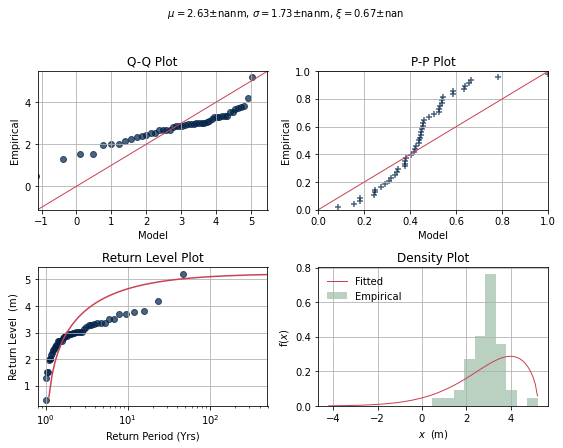

In [26]:
np_max = max_stage60['max'].to_numpy()
extremes(np_max[~np.isnan(np_max)])